# Linear models

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.special import gammaln
from theano import shared
plt.style.use('seaborn-darkgrid')

In [2]:
df = pd.read_csv('Howell1.csv', sep=';')

In [3]:
def plot_scatter(df):
    plt.figure(figsize=(10,10))
    plt.scatter(df['weight'], df['height'])
    plt.xlabel('weight')
    plt.ylabel('height')
    plt.show()

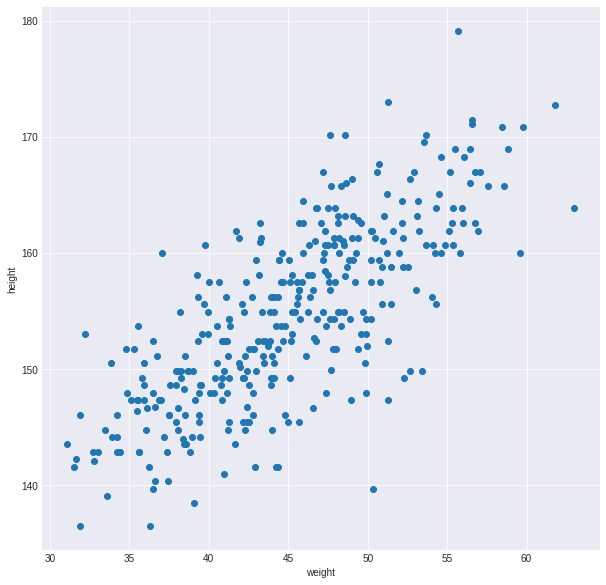

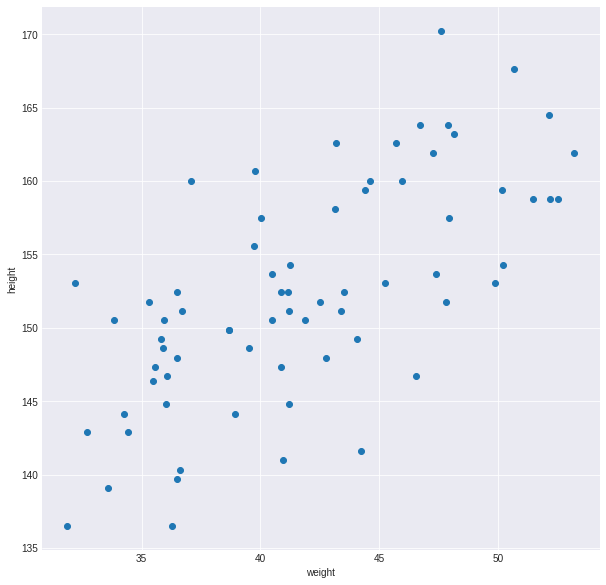

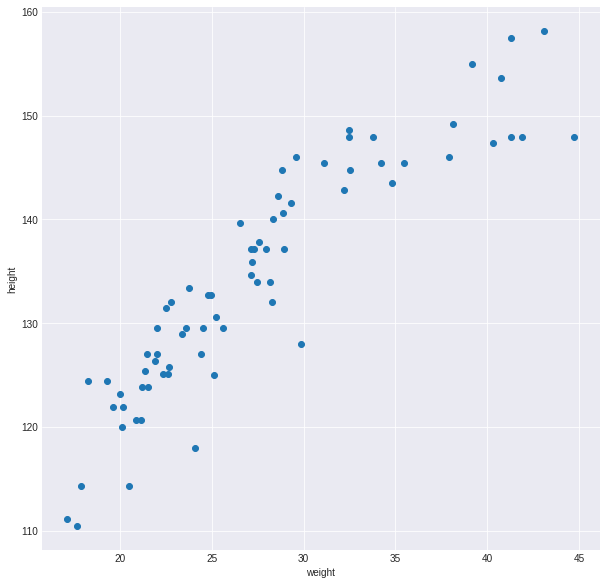

In [4]:
# I split data into 3 datasets (for different age intervals)
Y = [df[df.age >= 18], 
     df[df.age >= 55], 
     df[(df.age >= 10) & (df.age < 18)]]

for data in Y:
    plot_scatter(data)

In [46]:
# specify data
data = Y[0]
weight_shared = shared(data.weight.values)

In [6]:
import pymc3 as pm
basic_model = pm.Model()

with basic_model:
    # My prior assumptions 
    mu = pm.Normal('mu', 178, 20) 
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    # 95% of probability between 178 ± 40
    height = pm.Normal('height', mu, sigma, observed=data['height']) # likelihood

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:06<00:00, 1786.21draws/s]
The acceptance probability does not match the target. It is 0.8853455086233063, but should be close to 0.8. Try to increase the number of tuning steps.


mu     sigma
mu     0.171729  0.000100
sigma  0.000100  0.084276

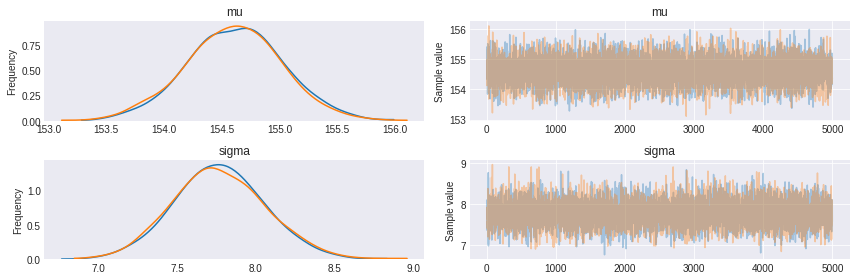

In [7]:
with basic_model:
    basic_trace = pm.sample(5000)

pm.traceplot(basic_trace)

trace_df = pm.trace_to_dataframe(basic_trace)
# covariance matrix
trace_df.cov()

In [8]:
pm.summary(basic_trace)

mean        sd  mc_error     hpd_2.5    hpd_97.5         n_eff  \
mu     154.611507  0.414382  0.003683  153.753509  155.397758  10083.042995   
sigma    7.771001  0.290288  0.003026    7.224429    8.358210  10166.324008   

           Rhat  
mu     1.000736  
sigma  0.999900

# We got Gaussian model of height in a population of adults. Now it's time for regression. Let's create linear model.


In [47]:
linear_model = pm.Model()
with linear_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('Intercept', mu=178, sd=30)
    beta = pm.Normal('x', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Expected value of outcome
#     mu = pm.Deterministic('mu', alpha + beta*weight_shared)
    mu = alpha + beta*weight_shared
    # Likelihood (sampling distribution) of observations
    height = pm.Normal('height', mu=mu, sd=sigma, observed=data.height)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, x, Intercept]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:33<00:00, 329.55draws/s]
The acceptance probability does not match the target. It is 0.8874089764867942, but should be close to 0.8. Try to increase the number of tuning steps.


Intercept         x     sigma
Intercept   3.658002 -0.079527  0.007914
x          -0.079527  0.001764 -0.000194
sigma       0.007914 -0.000194  0.038014

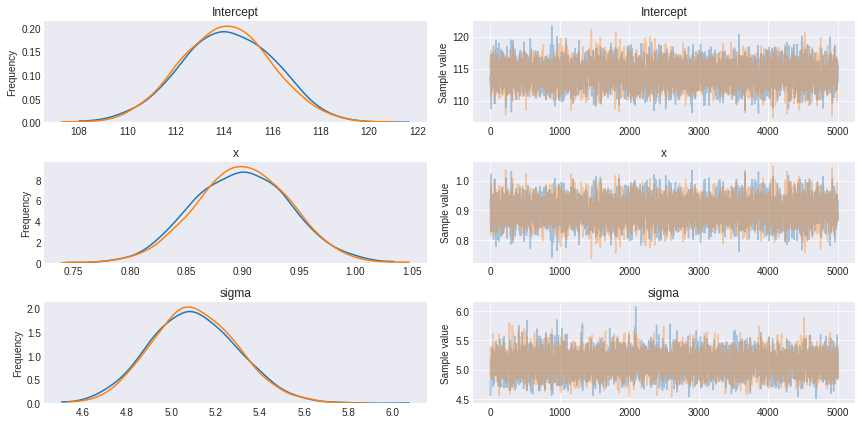

In [49]:
with linear_model:
    # draw 5000 posterior samples
    linear_model_trace = pm.sample(5000)

pm.traceplot(linear_model_trace)

trace_df = pm.trace_to_dataframe(linear_model_trace)
# covariance matrix
trace_df.cov()

In [11]:
pm.summary(linear_model_trace)

mean        sd  mc_error     hpd_2.5    hpd_97.5  \
Intercept  114.241519  1.952806  0.035338  110.488475  118.075984   
x            0.897142  0.042962  0.000783    0.811763    0.979745   
sigma        5.104684  0.196294  0.002940    4.731009    5.490898   

                 n_eff      Rhat  
Intercept  3274.599865  1.000051  
x          3253.438317  1.000114  
sigma      4434.827938  1.000010

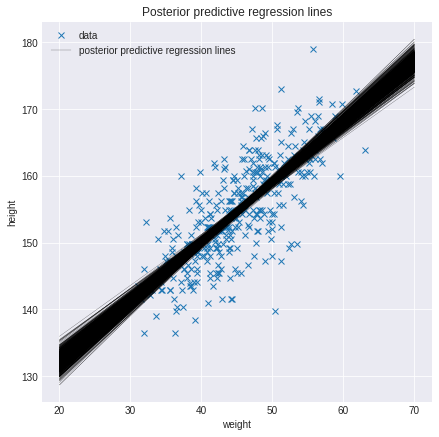

In [50]:
with linear_model:
    plt.figure(figsize=(7, 7))
    plt.plot(data.weight, data.height, 'x', label='data')
    pm.plot_posterior_predictive_glm(linear_model_trace, samples=1000, eval=np.linspace(20,70,100),
                                    label='posterior predictive regression lines')
    plt.title('Posterior predictive regression lines')
    plt.legend(loc=0)
    plt.xlabel('weight')
    plt.ylabel('height')

In [13]:
import arviz as az
# plt.figure(figsize=(10,10))
# alpha_m = linear_model_trace['Intercept'].mean()
# beta_m = linear_model_trace['x'].mean()
# plt.plot(data.weight, data.height, 'o', label='data')

# plt.plot(data.weight, alpha_m + beta_m * data.weight, c='k',          
#          label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x') 
# az.plot_hpd(data.weight, linear_model_trace['mu'], credible_interval=0.89, color='k') 
# az.plot_hpd(data.weight, linear_model_trace['mu'], credible_interval=0.5, color='b') 

# plt.xlabel('weight')
# plt.ylabel('height', rotation=0)
# plt.legend()

/home/kacper/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/kacper/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# H1

In [54]:
individual_weights = np.array([80.35, 69.72, 64.78, 100.59, 82.5, 10])
weight_shared.set_value(individual_weights)

In [55]:
pred_height = pm.sample_posterior_predictive(linear_model_trace, model=linear_model, samples=10000)
ys = pred_height['height']
y_hpd = pm.stats.hpd(ys, alpha=0.11)
y_hpd

100%|██████████| 10000/10000 [00:09<00:00, 1082.17it/s]


array([[177.83442763, 194.86165123],
       [168.20359961, 184.99955502],
       [164.05715508, 180.65706469],
       [195.6803693 , 213.48127941],
       [180.1699029 , 197.60873682],
       [115.07851984, 131.87809158]])

In [56]:
solution = pd.DataFrame({'individual':range(1,len(individual_weights)+1), 
                         'weight':individual_weights, 
                         'expected': np.mean(ys, axis=0),
                         'lower': y_hpd[:,0], 
                         'upper': y_hpd[:,1]})
solution

individual  weight    expected       lower       upper
0           1   80.35  186.457181  177.834428  194.861651
1           2   69.72  176.791514  168.203600  184.999555
2           3   64.78  172.419515  164.057155  180.657065
3           4  100.59  204.585659  195.680369  213.481279
4           5   82.50  188.380590  180.169903  197.608737
5           6   10.00  123.183607  115.078520  131.878092

# LOG model

In [17]:
#Logaritmic
log_model = pm.Model()

with log_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Expected value of outcome
    mu = pm.Deterministic('mu', alpha + beta*np.log(df.weight))

    # Likelihood (sampling distribution) of observations
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df.height)

In [18]:
with log_model:
    # draw 5000 posterior samples
    log_model_trace = pm.sample(5000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:32<00:00, 340.13draws/s]
The acceptance probability does not match the target. It is 0.88026200684775, but should be close to 0.8. Try to increase the number of tuning steps.


alpha      beta     sigma
alpha  1.838270 -0.520795 -0.001977
beta  -0.520795  0.151568  0.000625
sigma -0.001977  0.000625  0.024084

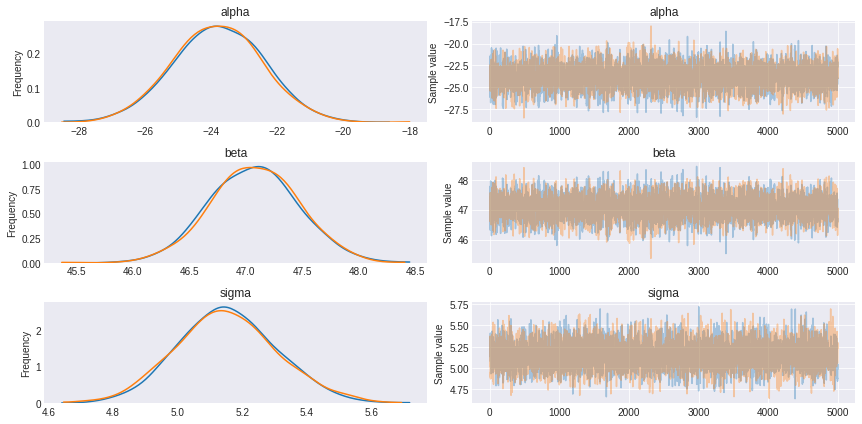

In [19]:
pm.traceplot(log_model_trace, varnames=['alpha', 'beta', 'sigma'])

trace_df = pm.trace_to_dataframe(log_model_trace, varnames=['alpha', 'beta', 'sigma'])
# covariance matrix
trace_df.cov()

In [20]:
pm.summary(log_model_trace, varnames=['alpha', 'beta', 'sigma'])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
alpha -23.780260  1.355760  0.021213 -26.369588 -21.060016  3910.657717   
beta   47.075031  0.389298  0.006109  46.284365  47.813389  3845.674635   
sigma   5.153831  0.155181  0.002167   4.852887   5.462741  5175.047430   

           Rhat  
alpha  1.000102  
beta   1.000087  
sigma  1.000105

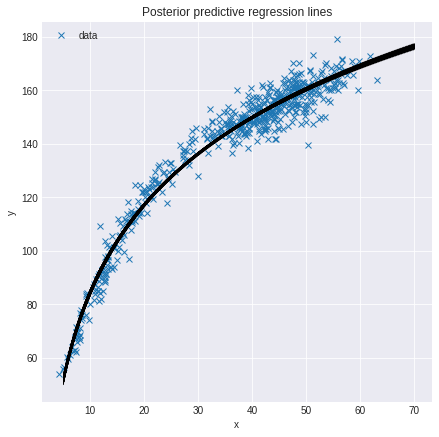

In [21]:
with log_model:
    plt.figure(figsize=(7, 7))
    plt.plot(df.weight, df.height, 'x', label='data')
    pm.plot_posterior_predictive_glm(log_model_trace, samples=1000, eval=np.linspace(5,70,100),lm= lambda x, sample: sample['alpha'] + sample['beta'] * np.log(x))
    plt.title('Posterior predictive regression lines')
    plt.legend(loc=0)
    plt.xlabel('x')
    plt.ylabel('y')

In [22]:
trace_df = pm.trace_to_dataframe(basic_trace)

trace_df.head()

mu     sigma
0  154.547985  7.831713
1  154.486490  8.024321
2  155.370767  7.668949
3  154.799947  8.026875
4  154.340166  7.945847

In [23]:
pm.hpd(basic_trace, 0.89)[0]['mu']

array([154.64756055, 154.75467313])

In [24]:
ppc_tlr = pm.sample_ppc(linear_model_trace, samples=1000, model=linear_model)
# ys = ppc_tlr['yl']
# y_hpd = pm.stats.hpd(ys, alpha=0.2)

/home/kacper/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 1000/1000 [00:00<00:00, 1083.77it/s]


In [25]:
ys = ppc_tlr['height']
y_hpd = pm.stats.hpd(ys, alpha=0.2)

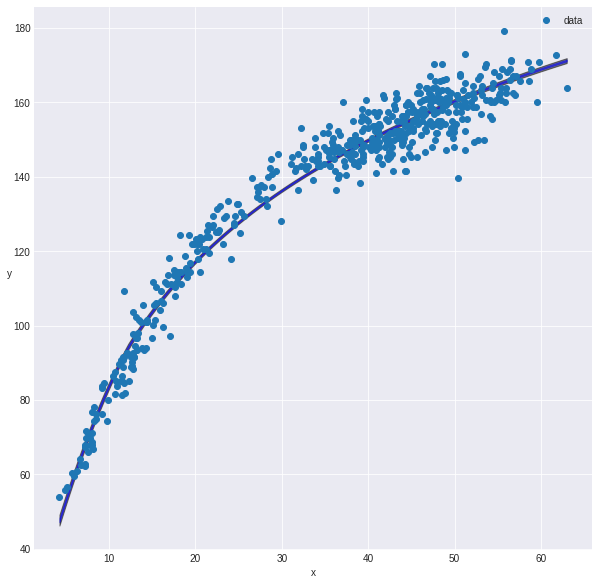

In [27]:
plt.figure(figsize=(10,10))

alpha_m = log_model_trace['alpha'].mean()
beta_m = log_model_trace['beta'].mean()
# plt.plot(df.weight, alpha_m + beta_m * np.log(df.weight), c='k',          
#          label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x') 
plt.plot(df.weight, df.height, 'o', label='data')

sig = az.plot_hpd(df.weight, log_model_trace['mu'], credible_interval=0.94, color='k') 
sig = az.plot_hpd(df.weight, log_model_trace['mu'], credible_interval=0.5, color='b') 

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

/home/kacper/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1c933dc18>,
      dtype=object)

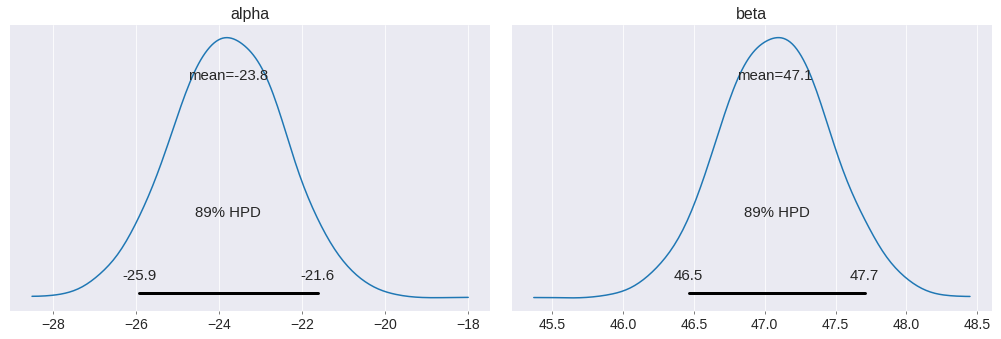

In [28]:
az.plot_posterior(log_model_trace, var_names=['alpha', 'beta'], credible_interval=0.89)

Plotting hpd interval.

/home/kacper/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
100%|██████████| 200/200 [00:00<00:00, 1271.64it/s]


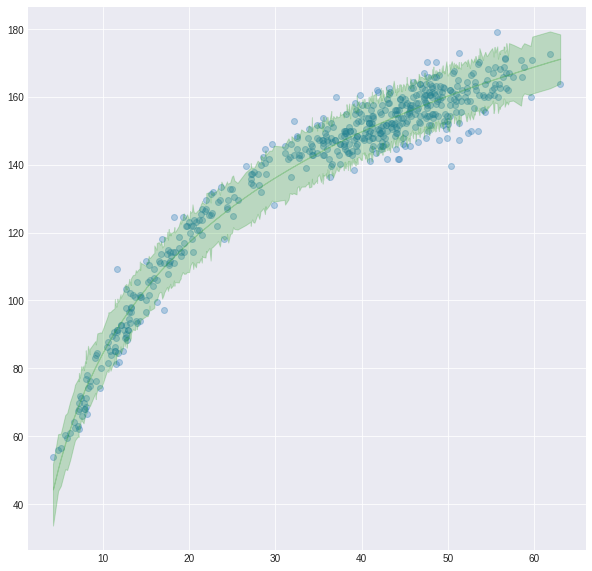

In [41]:
mu_pred = log_model_trace['mu']
idx = np.argsort(df.weight)
mu_hpd = pm.hpd(mu_pred, alpha=.89)[idx]

height_pred = pm.sample_ppc(log_model_trace, 200, log_model)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]
plt.figure(figsize=(10,10))
plt.scatter(df.weight, df.height, c='C0', alpha=0.3)
plt.fill_between(df.weight[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(df.weight[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25);